In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import datetime
import random

import re
sns.set()

from scipy.stats.mstats import winsorize
import scipy.stats
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


#%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.preprocessing import StandardScaler

In [9]:
df = pd.read_csv("./numeric_full.csv",  index_col='ID')



In [10]:
df.visceral_metastasis_location_ENCODEDmonths_survival.fillna(df.visceral_metastasis_location_ENCODEDmonths_survival.median(),inplace=True)

df.visceral_metastasis_location_ENCODEDspecific_death.fillna(df.visceral_metastasis_location_ENCODEDspecific_death.median(),inplace=True)

df.total_positives_slnb_ldn_ENCODEDspecific_death.fillna(df.total_positives_slnb_ldn_ENCODEDspecific_death.median(),inplace=True)   
df.total_positives_slnb_ldn_ENCODEDmonths_survival.fillna(df.total_positives_slnb_ldn_ENCODEDmonths_survival.median(),inplace=True)



In [11]:
x=df.drop(columns=['specific_death', 'months_survival'])
y=df[['specific_death','months_survival','train']]


In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=9, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(x[x['train'] == 1]._get_numeric_data())


ValueError: 'n_components' should be inferior to 4 for the barnes_hut algorithm as it relies on quad-tree or oct-tree.

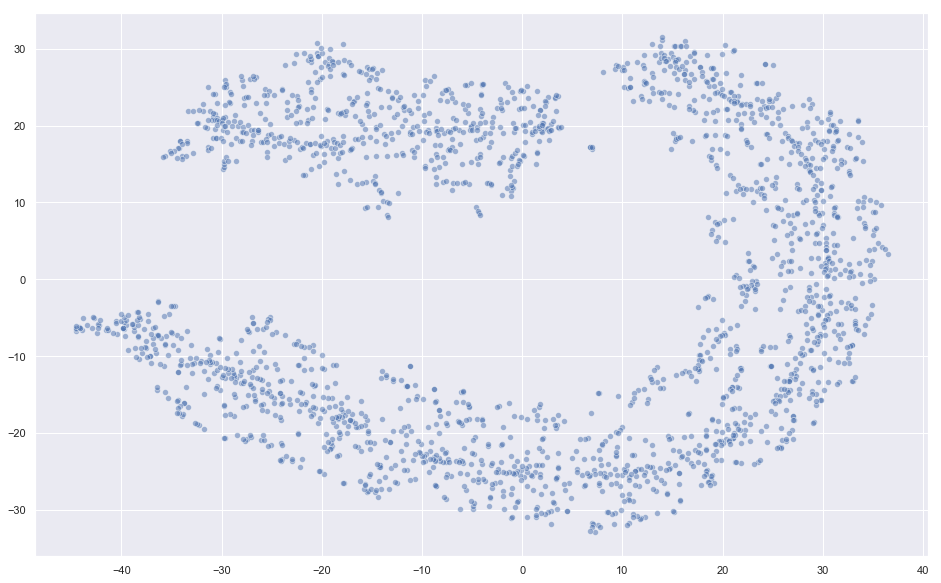

In [18]:
df_subset = {
    'tsne-2d-one': tsne_results[:,0],
    'tsne-2d-two': tsne_results[:,1],
    'y': y[y['train'] == 1]['specific_death'].values
}

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    #hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.5
)

In [ ]:
len(df_subset['y'])

In [ ]:
ts=pd.DataFrame(tsne_results)

print(ts.shape)
ts[0]

In [ ]:
x['tsne0']=ts[0]
x['tsne1']=ts[1]
x['tsne2']=ts[2]

In [ ]:
df.shape()

In [ ]:
type(ts)

In [ ]:
x=pd.DataFrame(x)
type(x)

In [ ]:
xx = pd.concat([x,ts],axis=1)

In [ ]:
xx.head()

In [ ]:
xx.isna().sum()

In [ ]:
# Standardizing the features
x = StandardScaler().fit_transform(xx._get_numeric_data())

from sklearn.decomposition import PCA
pca = PCA(n_components=60)
principalComponents = pca.fit_transform(x)

In [ ]:
pc=pd.DataFrame(principalComponents)
print(pc.shape)
pc.head()

In [ ]:
pc.shape

In [ ]:
pc.index=df.index
pc['train']=df['train']
#pc['cutaneous_biopsy_breslow']=df['cutaneous_biopsy_breslow']
#pc['cutaneous_biopsy_mitotic_index']=df['cutaneous_biopsy_mitotic_index']
pc.head()

In [ ]:
train = pc[pc['train'] == 1]
test = pc[pc['train'] == 0]

In [ ]:
#!/usr/bin/python
"""
Copyright 2019 Accenture and/or its affiliates.  All Rights Reserved.  
You may not use, copy, modify, and/or distribute this code and/or its documentation without permission from Accenture.
Please contact the Advanced Analytics-Operations Analytics team and/or Frode Huse Gjendem (lead) with any questions.

\brief This is the starter script for the Accenture's Health Datathon 2019 competition.

\version 1.0

\date $Date: 2019/05

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



'''
Function to select certain/uncertain weights
You will not need to ever create the following parameters
They are created (and this is called) within the next function "calc_weights"
@paramters
    patient_info: vector holding every month you want to evaluate, 1 for whichever column months_survived = 1, NA otherwise
    df_aux: vector that contains the probability of survival at each month, fixed values for a test set
@return
    the vector of weights

'''
def get_weights(patient_info, df_aux):
    x = np.array(patient_info)
    
    # weight will always be 1 if we know they are dead
    if (x[~np.isnan(x)][0]==1):
        x = np.ones_like(x)
    else:
        y = np.argwhere(~np.isnan(x))
        not_zero_index = y.ravel()[0]
        
        x[:not_zero_index] = 1
        x[not_zero_index:] = df_aux['prob'][not_zero_index:]
    return (x)


'''
Function to calculate the weight matrix
@paramters
    y_df: The test set for which you are calculating the weights
        Format: Index = ID, Rows = patients, cols = ['specific_death', 'months_survival']
@ return
    the weights matrix with the weights for each patient at each time t  
'''
def calc_weights(y_df):
    
    # Create a matrix with patient id in the index and months_survival as header, specific_death as values.   
    df_y_pivot = y_df.pivot(columns="months_survival", values='specific_death')
    # The table changes order of rows after pivoting it, we need to reorder it again by doing reindex_axis.
    df_y_pivot= df_y_pivot.reindex(y_df.index, axis=0).reset_index()
    
    # We need to calculate the weights based on the entire time initially, then cut it off after the fact
    all_months_survival = np.arange(0,y_df.months_survival.max()+1)
    months_complementary = np.setdiff1d(all_months_survival, y_df.months_survival.unique())
    df_complementary = pd.DataFrame(np.nan, index=df_y_pivot.index, columns=months_complementary )
    df_y_pivot = pd.concat([df_y_pivot,df_complementary],axis=1)[all_months_survival]
    
    # Get aux matrix to provide in the get_weights function. 
    # Probability of being alive at each month based on patients you are certain about (excluding patients censored pior to month)
    df_aux = pd.DataFrame(data=np.arange(0,y_df.months_survival.max()+1),columns=["months_survival"])
    df_aux['prob_num'] = df_aux['months_survival'].apply(lambda x : (y_df['months_survival'] > x).values.sum())
    df_aux['prob_den'] = df_aux['months_survival'].apply(lambda x : ((y_df['months_survival'] < x) & (y_df['specific_death']==1)).values.sum())
    df_aux['prob'] = (df_aux['prob_num']/(df_aux['prob_num']+df_aux['prob_den']))

    df_aux = df_aux[['months_survival','prob']].sort_values('months_survival').reset_index().drop('index',axis=1)

    
    #Get weights
    df_weights = df_y_pivot.apply(lambda x: get_weights(x,df_aux),axis=1)
    
    new_weights = pd.DataFrame(np.vstack(df_weights),columns=all_months_survival )

    new_weights = np.apply_along_axis(np.cumprod, 1, new_weights)
    
    new_weights = pd.DataFrame(new_weights)
    
    return new_weights


''' 
Fill up the Y_true matrix's value 
You will not need to ever creat the following parameter.
It is created (and this is called) within the next function "populate_actual".
@paramters
    patient_info: vector holding every month you want to evaluate, 1 for whichever column months_survived = 1, NA otherwise
'''
def apply_non_zero(patient_info):
    x = np.array(patient_info)
    if (x[~np.isnan(x)][0]==0):
        x = np.ones_like(x)
    else:
        y = np.argwhere(~np.isnan(x))
        not_zero_index = y.ravel()[0]
        x[:(not_zero_index)] = 1
        x[(not_zero_index):] = 0   

    return (pd.Series(x))

 
'''
Build the Y_true matrix
@paramters
    y_df: The test set for which you are calculating the weights
        Format: Index = ID, Rows = patients, cols = ['specific_death', 'months_survival']
    years: Number of years for which you want to evaluate your model. Default = 10.
'''
def populate_actual(y_df, years = 10):
    #Create a matrix by pivoting table
    df_y_true_pivot = y_df.pivot(columns = "months_survival", values='specific_death')
    #The table changes order of rows after pivoting it, we need to reorder it again by doing reindex_axis.
    df_y_true_pivot = df_y_true_pivot.reindex(y_df.index, axis=0).reset_index()


    all_months_survival = np.arange(0,y_df.months_survival.max()+1)
    #Get the month that we don't have any patient record in our dataset.
    
    months_complementary = np.setdiff1d(all_months_survival, y_df.months_survival.unique())
    df_complementary = pd.DataFrame(np.nan, index=df_y_true_pivot.index, columns=months_complementary )
    
    #Add the complementary dataframe to create a full-month dataframe
    df_y_true_pivot = pd.concat([df_y_true_pivot,df_complementary],axis=1)[all_months_survival]

    # Fill NaN value to either 0 or 1
    df_y_pro = df_y_true_pivot.apply(lambda x: apply_non_zero(x),axis=1)
    
    
    chosen_months_survival = np.arange(0,years*12+1)
    df_y_pro = df_y_pro[chosen_months_survival].values
    
    return df_y_pro


'''
Function to compute the weighted Brier score
@paramters
    pred: is the prediction matrix
        Format: Index = ID, Rows = patients, cols = months, values = probability of being alive (alive = 1, dead = 0)
    actual: is the actual value matrix.
        Format: Index = ID, Rows = patients, cols = ['specific_death', 'months_survival']
    weights: is the matrix of weights associated to the predictions
    years_cutoff: is the time for which the error is computed
@return
    the vector of actual status over time
'''
def brier_score_loss_weighted(pred, actual, weights, years_cutoff = 10):
    
    # Select the desired period
    weights = weights.iloc[:,:(12*years_cutoff)+1]
    
    # obtain the unique time values in the y data of your survival data
    unique_times = range(0, (12*years_cutoff)+1)
    
    # fill an empty matrix to hold the weights
    errors = np.empty([len(actual), len(unique_times)])
    
    # subset y_pred to be the number of years you want
    m_y_pred = pred.iloc[:,:(max(unique_times)+1)]

    try:
        m_y_true = np.matrix(populate_actual(actual, years_cutoff))
        m_y_pred = np.matrix(m_y_pred)
        m_weights = np.matrix(weights)
    except:
        print("Matrix format is required for y_true, y_predict and weights")
            
    errors = np.multiply(np.power(m_y_pred - m_y_true,2),m_weights)
    
    error = pd.DataFrame(errors)
    time = years_cutoff * 12
    
    # calculate the average error of all patients for each time
    all_dates = error.mean(axis=0)
    
    # subset desired dates
    desired_dates = pd.DataFrame(all_dates[0:(time+1)])
    
    # calculate the average error up until a point in time
    desired_error = np.mean(desired_dates)
    
    return desired_error

In [ ]:
# Feature selection
b_x_train = train.drop(columns='train')
b_y_train = y.query('train==1')[['specific_death', 'months_survival']]

In [ ]:
b_test = test.drop(columns='train')

In [ ]:
b_y_train.isnull().sum()

In [ ]:
def fit_and_prepare(x_train, y_train, test_df):
    
    # 3.1. Prepare Y-----
    y_train.specific_death = y_train.specific_death.astype(bool)
    
    # Transform it into a structured array
    y_train = y_train.to_records(index = False)
    
    # 3.2. Prepare X-----
    # obtain the x variables that are categorical
    categorical_feature_mask = x_train.dtypes==object

    # Filter categorical columns using mask and turn it into a list
    categorical_cols = x_train.columns[categorical_feature_mask].tolist()

    # Ensure categorical columns are category type
    for col in categorical_cols:
        x_train[col] = x_train[col].astype('category')
        test_df[col] = test_df[col].astype('category')
    
    # 3.3. Fit model-----
    # initiate
    encoder = OneHotEncoder()
    estimator = CoxPHSurvivalAnalysis(alpha=1000)
    
    # fit model
    estimator.fit(encoder.fit_transform(x_train), y_train)
    
    # transform the test variables to match the train
    x_test = encoder.transform(test_df)
    
    return (estimator, x_test, x_train, y_train)

In [ ]:
estimator, x_test, x_train, y_train = fit_and_prepare(b_x_train,b_y_train, test)

In [ ]:
estimator_b, x_test_b, x_train_b, y_train_b = fit_and_prepare(b_x_train, b_y_train, b_test)

In [ ]:
pred_surv = estimator.predict(x_test)
pred_surv[0]

In [ ]:
x_test.head()

In [ ]:
def get_probabilities(x_test, estimator):
    
    pred_surv = estimator.predict_survival_function(x_test)

    # Get the "X's" or time of each data point
    times = pred_surv[0].x

    # Create an empty pandas dataframes with these times as the columns
    pred_df = pd.DataFrame(columns = times)

    # Convert each row to a pandas series row (transpose) with the index as these x times and append it to the df
    for i in range(0, len(x_test)):
        pred_df = pred_df.append(pd.DataFrame(pred_surv[i].y).set_index(times).T) 

    pred_df = pred_df.set_index(x_test.index)

    return pred_df

In [ ]:
# 4.2 store the predictions
predictions_b = get_probabilities(x_test_b, estimator_b)

In [ ]:
y_train

In [ ]:
predictions_b

In [ ]:
# 4.3 Compute estimate of the survival curves
pred_curves = estimator_b.predict_survival_function(x_test_b)

In [ ]:
for curve in pred_curves[0:3]:
    plt.step(curve.x, curve.y, where="post")

In [ ]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(x_train)
result = concordance_index_censored(y_train['specific_death'], 
                                    y_train["months_survival"],
                                    prediction)
result[0]

In [ ]:
from sksurv.metrics import concordance_index_censored

pred_b = estimator_b.predict(x_train_b)
result = concordance_index_censored(y_train_b['specific_death'], 
                                    y_train_b["months_survival"],
                                    pred_b)
result[0]

In [ ]:
predictions_df = pd.DataFrame(predictions_b)

In [ ]:

# Please, remember that rows NEED TO BE indexed by patient IDs and columns MUST be ordered from T0 to T120

# First subset to 10 years
predictions_10yr = predictions_df.iloc[:,:121]

#Rename columns to Time periods
columns = predictions_10yr.columns.values
new_columns = ['T' + str(s) for s in columns]
predictions_10yr.columns = new_columns

# Write the final CSV file
# Please, remember than in order to make the submission you need to create a .zip file ONLY with the csv
pd.DataFrame(predictions_10yr).to_csv('sample-submission-cox.csv')

In [ ]:
pd.DataFrame(predictions_10yr)

In [ ]:
predictions_df.index = test.index
predictions_df

In [ ]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(b_x_train.values, b_y_train)
#pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

In [ ]:
b_y_train